#Connect to Drive

In [38]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Installing detectron2

In [39]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-mrf_mio6
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-mrf_mio6
  Resolved https://github.com/facebookresearch/detectron2.git to commit 898507047cf441a1e4be7a729270961c401c4354
  Preparing metadata (setup.py) ... done


# Import Libraries

In [40]:
!pip cache purge

Files removed: 4


In [41]:
!python -m pip install --upgrade pip


In [83]:
#install pyyaml

!python -m pip install pyyaml==5.1

#import librariies
import torch , random, os , json
import numpy as np
import cv2
from google.colab.patches import cv2_imshow


#detectron2
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
from detectron2 import model_zoo
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg

from detectron2.engine import DefaultTrainer


  Using cached PyYAML-5.1.tar.gz (274 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


# Data Preparation

In [87]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("helmets_train", {}, "/content/gdrive/MyDrive/Colab Notebooks/Datasets/Bicycle Helmet Detection.v2i.coco/train/_annotations.coco.json", "/content/gdrive/MyDrive/Colab Notebooks/Datasets/Bicycle Helmet Detection.v2i.coco/train")


AssertionError: ignored

In [88]:
helmet_metadata = MetadataCatalog.get("helmets_train")
dataset_dicts = DatasetCatalog.get("helmets_train")

WARNING [10/24 10:22:41 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[10/24 10:22:41 d2.data.datasets.coco]: Loaded 8722 images in COCO format from /content/gdrive/MyDrive/Colab Notebooks/Datasets/Bicycle Helmet Detection.v2i.coco/train/_annotations.coco.json


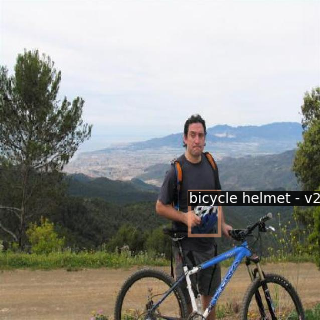

In [89]:
#randomly selects dataset dictionary, reads the image
#converts it to RGB format, draws the dictionary on the image, and displays the resulting visualization

for d in random.sample(dataset_dicts, 1):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=helmet_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

# Model Training

In [90]:
#gets a new copy of the default configuration for Faster R-CNN
cfg_r_101f = get_cfg()

#merges the pre-trained model configuration from the COCO dataset into the new configuration
cfg_r_101f.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml"))


cfg_r_101f.DATASETS.TRAIN = ("helmets_train",)
cfg_r_101f.DATASETS.TEST = ()

# number of worker processes to use for data loading
cfg_r_101f.DATALOADER.NUM_WORKERS = 0
cfg_r_101f.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml")

#training parameters
cfg_r_101f.SOLVER.IMS_PER_BATCH = 2
cfg_r_101f.SOLVER.BASE_LR = 0.0025
cfg_r_101f.SOLVER.MAX_ITER = 300
cfg_r_101f.SOLVER.STEPS = []
cfg_r_101f.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 4096
cfg_r_101f.MODEL.ROI_HEADS.NUM_CLASSES = 2

#creates the output directory
os.makedirs(cfg_r_101f.OUTPUT_DIR, exist_ok=True)

#create a new trainer object
trainer = DefaultTrainer(cfg_r_101f)
trainer.resume_or_load(resume=False)
trainer.train()

[10/24 10:23:06 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[10/24 10:23:07 d2.engine.train_loop]: Starting training from iteration 0
[10/24 10:23:16 d2.utils.events]:  eta: 0:01:56  iter: 19  total_loss: 1.026  loss_cls: 0.8126  loss_box_reg: 0.02567  loss_rpn_cls: 0.1164  loss_rpn_loc: 0.01162    time: 0.4073  last_time: 0.4296  data_time: 0.0503  last_data_time: 0.0477   lr: 0.00016068  max_mem: 3652M
[10/24 10:23:24 d2.utils.events]:  eta: 0:01:51  iter: 39  total_loss: 0.2367  loss_cls: 0.1171  loss_box_reg: 0.03452  loss_rpn_cls: 0.06997  loss_rpn_loc: 0.01238    time: 0.4208  last_time: 0.4683  data_time: 0.0580  last_data_time: 0.0490   lr: 0.00032718  max_mem: 3652M
[10/24 10:23:33 d2.utils.events]:  eta: 0:01:41  iter: 59  total_loss: 0.2092  loss_cls: 0.08622  loss_box_reg: 0.05616  loss_rpn_cls: 0.06576  loss_rpn_loc: 0.01001    time: 0.4196  last_time: 0.4893  data_time: 0.0500  last_data_time: 0.0798   lr: 0.00049367  max_mem: 3652M
[10/24 10:23:41 d2.utils.events]:  eta: 0:01:32  iter: 79  total_loss: 0.3452  loss_cls: 0.1296  lo

# Loading Trained Model

In [91]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg_r_101f.MODEL.WEIGHTS = os.path.join(cfg_r_101f.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg_r_101f.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6  # set a custom testing threshold
predictor = DefaultPredictor(cfg_r_101f)

[10/24 10:25:21 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


# Testing Model

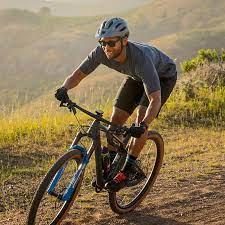

In [100]:
from google.colab.patches import cv2_imshow
import cv2

# Load your image using OpenCV
image = cv2.imread('/content/Test/test.jpeg')

# Display the image using cv2_imshow()
cv2_imshow(image)

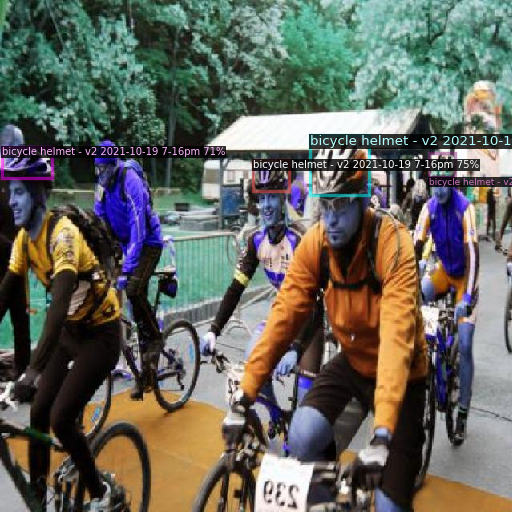

In [114]:
from detectron2.utils.visualizer import ColorMode

def rgb2bgr(image):
  return cv2.cvtColor(image, cv2.COLOR_RGB2BGR)


for img in os.listdir("/content/Test/"):
  if img[-3:-1] == "jp":
    image = "/content/Test/"+img
    im = cv2.imread(image)
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=helmet_metadata,
                   scale=0.8,
                   instance_mode=ColorMode.IMAGE
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    image = out.get_image()[:, :, ::-1]
    image = rgb2bgr(image)
    cv2_imshow(image)

# Evaluation

In [116]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("helmet_train_data1")
val_loader = build_detection_test_loader(cfg_r_101f, "helmet_train_data1")
print(inference_on_dataset(trainer.model, val_loader, evaluator))
print("Another way of testing")
print(trainer.test)

WARNING [10/24 10:44:09 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[10/24 10:44:09 d2.data.datasets.coco]: Loaded 8722 images in COCO format from /content/gdrive/MyDrive/Colab Notebooks/Datasets/Bicycle Helmet Detection.v2i.coco/train/_annotations.coco.json
[10/24 10:44:10 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[10/24 10:44:10 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[10/24 10:44:10 d2.data.common]: Serializing 8722 elements to byte tensors and concatenating them all ...
[10/24 10:44:10 d2.data.common]: Serialized dataset takes 3.62 MiB
[10/24 10:44:10 d2.evaluation.evaluator]: Start inference on 8722 batches
[10/24 10:44:11 d2.evaluation.evaluator]: Inference done 11/8722. Dataloading: 0.0312 s/iter. Inference: 0.0753 s/iter. Eval: 0